## Table of Contents

* データを知る
    * スキーマを理解する
    * 現象を理解する
    * 実際にデータを眺める
* python を使ったデータの理解
    * train / test の Report をさっくり作る
    * 学習用のデータと予測するデータの差分を知る
* モデリングのための特徴量作成
    * 連続変数の特徴量
    * Boolean の特徴量
* LightGBM でモデル作る
    * CrossValidation とは / なんで CrossValidation するの?
    * LightGBM でのモデリング・パラメータ
    * 特徴重要度 (FeatureImporatnce) の可視化
    * モデルを使って予測・submissionの作成

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
!pip install texthero
import texthero as hero
import nltk
import matplotlib
matplotlib.use("TkAgg")
%matplotlib inline
sns.set_style('ticks')

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [3]:
train_df.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [4]:
report = ProfileReport(train_df)
report

Summarize dataset:  78%|███████▊  | 21/27 [00:02<00:01,  4.13it/s, Calculate phi_k correlation]     

In [ ]:
'''
そのまま使えそうな特徴量は，Year_of_release,Critic_Score,Critic_count
'''

'\nそのまま使えそうな特徴量は，Year_of_release,Critic_Score,Critic_count\n'

Text(0.5, 1.0, 'Year_of_Release')

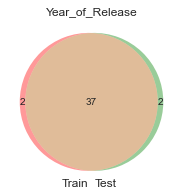

In [ ]:
c='Year_of_Release'

fig,ax=plt.subplots(figsize=(5,3))
venn2(
    subsets=(set(train_df[c].unique()),set(test_df[c].unique())),
    set_labels=('Train','Test'),
    ax=ax
)
ax.set_title(c)

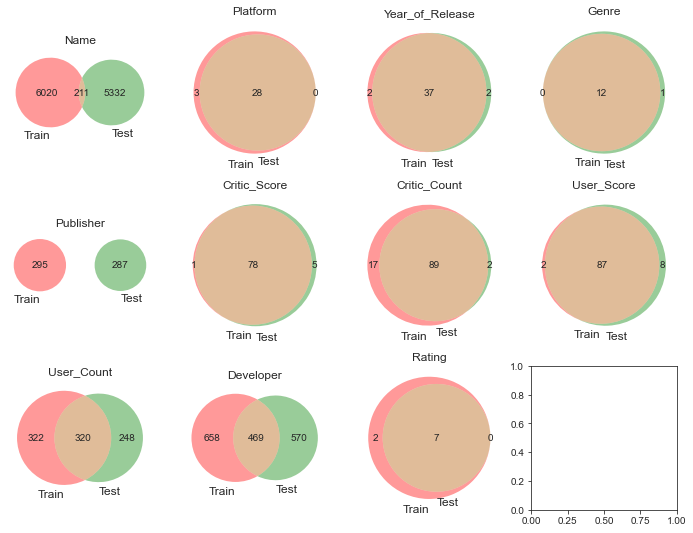

In [ ]:
colunms=test_df.columns
n_figs=len(colunms)
n_cols=4
n_rows=n_figs//n_cols+1

fig,axes=plt.subplots(figsize=(n_cols*3,n_rows*3),ncols=n_cols,nrows=n_rows)
for c,ax in zip(colunms,axes.ravel()):
    venn2(
    subsets=(set(train_df[c].unique()),set(test_df[c].unique())),
    set_labels=('Train','Test'),
    ax=ax
    )
    ax.set_title(c)



In [ ]:
'''
NameとPublisherは要注意．
User_Count,Developerも少し偏っている？
'''

'\nNameとPublisherは要注意．\nUser_Count,Developerも少し偏っている？\n'

## モデリングのための特徴量作成

### 特徴量とは何か

予測変数に紐付いた説明変数のことを「特徴量」と呼びます。近年の進歩でたくさんのアルゴリズムが開発され予測能力は向上していますが、アルゴリズムに入力するデータは人間が用意しなくてはなりません。この予測の元になるデータを特徴量とよび、アルゴリズムが理解しやすい特徴量を作ることを特徴量エンジニアリングと呼びます。

### どうやって作れば良い?

基本的に人間が予測する時と同じように「何があったら予測しやすいかなあ」を考えていくことが多いです。

### 連続変数の特徴量

連続変数の場合そのままモデルが解釈出来るため、基本的にはそのまま予測に用いることが可能です。

#### 欠損値の処理

通常欠損値があると欠損のことを考慮する必要があります(モデルによっては欠損値が扱えない場合があるからです)。その場合平均値や中央値、更には別の方法で欠損を埋める必要がありますが lightGBM などの GBDT は欠損をそのまま自然に扱えるため、基本的に気にする必要はありません。

#### 暗黙的な仮定を意識する

連続変数とみなす場合には、その大小関係に意味があると思っていることと同値であることに注意してください。大小関係に意味がない値の場合には、連続変数ではなくて、カテゴリ変数とみなして処理を行ったほうが適切な場合があります。

勾配ブースティングのように連続値とみなしてもある程度うまくやってくれるアルゴリズムではそこまでシビアに考える必要はありませんが、線形モデルのように値の大小と予測結果が線形に比例するようなモデルでは大小に意味がないものを連続値として扱うと予測性能が悪化する場合があります。  
(例えば「ユーザーごとの缶コーヒー購買量」を予測するときに「年齢」を数値としてみなしてよいか?)

よく知られている例では時間 (0-24)があります。時間は 0 と 24 がつながっている (1週して元に戻ってくる) ので1次元で表現せずに極座標の角度として捉えて cos(hour / 12 pi) / sin (hour / 12 * pi) の2次元で表現する、等があります。

In [ ]:
test_df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
       'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
       'Rating'],
      dtype='object')

In [ ]:
def preprocess(input_df:pd.DataFrame)->pd.DataFrame:
    out_df=input_df.copy()
    out_df['User_Score']=input_df['User_Score'].replace('tbd',None).astype(float)
    return out_df

def create_continuous_features(input_df):
    input_df=preprocess(input_df)
    out_df=pd.DataFrame()
    use_columns=['Year_of_Release','Critic_Score','Critic_Count',
    'User_Score', 'User_Count']
    out_df[use_columns]=input_df[use_columns]    
    return out_df

In [ ]:
assert len(create_continuous_features(train_df)) == len(train_df)
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

### Booleanの特徴量

特定の条件を満たしているかどうか, を表す特徴量です。例えばテキストカラムに特定の文字列が存在しているかどうか、などが該当します。

In [ ]:
def create_boolean_feature(input_df):
    out_df=pd.DataFrame()
    texts=['nintendo','sega','capcom']
    for t in texts:
        out_df[f'Developer_has_{t}']=input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return out_df

In [ ]:
create_boolean_feature(train_df).sum()

Developer_has_nintendo     88
Developer_has_sega         59
Developer_has_capcom      132
dtype: int64

In [ ]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_boolean_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [ ]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)
assert len(test_feat_df) == len(test_df)

  0%|          | 0/2 [00:00<?, ?it/s]

create create_continuous_features 0.090[s]
create create_boolean_feature 0.035[s]
create create_continuous_features 0.048[s]


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

create create_boolean_feature 0.212[s]


## LightGBM による学習

特徴量を作成できたので、次に LightGBM による学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

> 仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は `KFold` と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。(今回行なうのはこの方法です)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

あとは「各分割で特定のグループが重ならないようにする」Group K Fold もよく使われます。(よく見ると 0 ~ 4 で group の行の色が被らないようになっているのわかりますか?)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

その他にも時系列で区切る time split という方法もあります。どれを使えばよいかは test データがどのように構成されているか依存なので、つどつどデータを見て決定します。

### CrossValidation の注意点

cross validation を行なう場合には train / test の関係性と cv の各 fold での学習・検証データの関係性が出来る限り似た関係性になる必要があります。これは fold ごとの学習で、train 全体で学習したときの test での性能を近似する必要があるためです。したがって今渡されている train / test の関係性を考えたうえで CV の方法についても考える必要があります。(特にtestが未来の情報である場合などとても大切です)

In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=10):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        # 今回はglobal sales はゼロ以下になるわけがないので 0 以下は 0 に丸める
        pred_i = np.where(pred_i < 0, 0, pred_i)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。

In [ ]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values
y=np.log1p(y)

In [ ]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [ ]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 1.22244
[20]	valid_0's rmse: 1.16404
[30]	valid_0's rmse: 1.14853
[40]	valid_0's rmse: 1.14505
[50]	valid_0's rmse: 1.14428
[60]	valid_0's rmse: 1.14363
[70]	valid_0's rmse: 1.14123
[80]	valid_0's rmse: 1.14102
[90]	valid_0's rmse: 1.14205
Early stopping, best iteration is:
[81]	valid_0's rmse: 1.14082
fit fold=1 1.101[s]
Fold 0 RMSLE: 1.1408
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 1.25079
[20]	valid_0's rmse: 1.20025
[30]	valid_0's rmse: 1.18642
[40]	valid_0's rmse: 1.18204
[50]	valid_0's rmse: 1.18059
[60]	valid_0's rmse: 1.18006
[70]	valid_0's rmse: 1.17871
[80]	valid_0's rmse: 1.17793
[90]	valid_0's rmse: 1.17715
[100]	valid_0's rmse: 1.17797
Early stopping, best iteration is:
[93]	valid_0's rmse: 1.17688
fit fold=2 0.625[s]
Fold 1 RMSLE: 1.1769
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 1.19028
[20]	valid_0's rmse: 1.134

### Note

* lightGBM を `RMSE` の意味で学習させました (`objective="rmse"`)。RMSEはノイズが正規分布に従っていると仮定したモデルですが、今回のデータでは成り立っているでしょうか。
* 評価指標は `RMSLE` で `RMSE` とずれています。できれば `RMSLE` の意味で最適化することが良いはずです (ことこのコンペにおいては). RMSLE の意味で最適化する方法はないでしょうか。

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

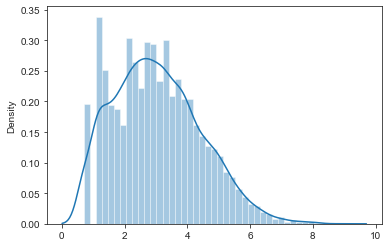

In [ ]:
sns.distplot(y)

### 特徴重要度の確認

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

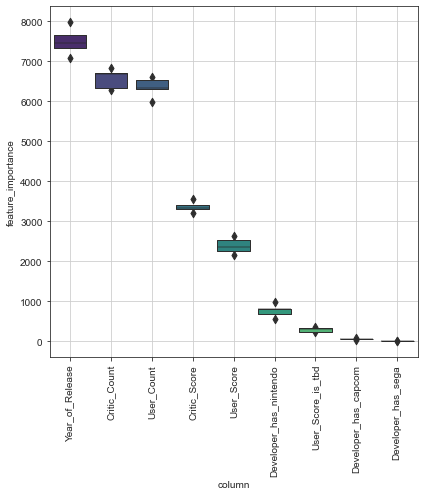

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred=np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv('simple_submission.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


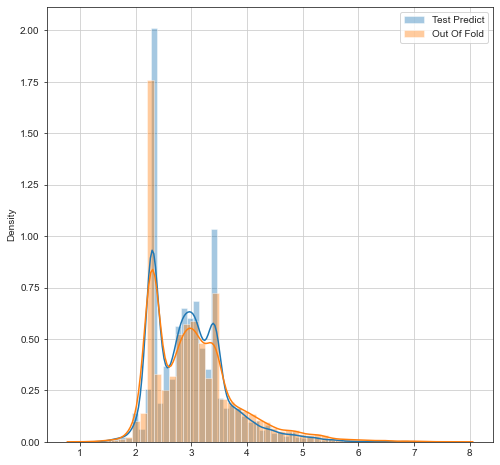

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof,label='Out Of Fold')
ax.legend()
ax.grid()

## 第二回
* モデルの改善
* EDA


In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
!pip install texthero
import texthero as hero
import nltk
import matplotlib
matplotlib.use("TkAgg")
%matplotlib inline
sns.set_style('ticks')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

whole_df = pd.concat([train_df, test_df], ignore_index=True)

## 特徴量作成

In [ ]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    idx_tbd = (input_df['User_Score'] == 'tbd')
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)
    
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [ ]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

In [ ]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    texts = [
        'japan', 'nintendo','capcom','sega'
    ]
    
    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [ ]:
create_boolean_feature(train_df).sum()

Developer_has_japan        23
Developer_has_nintendo     88
Developer_has_capcom      132
Developer_has_sega         59
dtype: int64

### CountEncoding

In [ ]:
#抽象クラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
        
    def transform(self, input_df):
        raise NotImplementedError()

In [ ]:
_df=train_df.groupby('Name')['Platform'].count()
pd.merge(train_df['Name'],_df,on='Name',how='left').values[:,1].astype(int)

array([7, 4, 7, ..., 1, 2, 2])

In [ ]:
vc=train_df['Name'].value_counts()
vc

Ratatouille                                      9
LEGO Marvel Super Heroes                         9
The LEGO Movie Videogame                         8
Lego Batman 3: Beyond Gotham                     8
LEGO Jurassic World                              8
                                                ..
BeyBlade VForce: Super Tournament Battle         1
Shin Megami Tensei: Nocturne                     1
Diabolik Lovers                                  1
Samurai Warriors 2: Xtreme Legends (JP sales)    1
Ratchet & Clank (2016)                           1
Name: Name, Length: 6231, dtype: int64

In [ ]:
train_df['Name'].map(vc)

0       7
1       4
2       7
3       1
4       8
       ..
8354    1
8355    1
8356    1
8357    2
8358    2
Name: Name, Length: 8359, dtype: int64

In [ ]:
class CountEncodingBlock(BaseBlock):
    def __init__(self,column,whole_df:pd.DataFrame):
        self.column=column
        self.whole_df=whole_df
    
    def transform(self,input_df):
        output_df=pd.DataFrame()
        c=self.column
        cv=self.whole_df[c].value_counts()
        output_df[c]=input_df[c].map(cv)
        return output_df.add_prefix('CE_')



In [ ]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
CountEncodingBlock('Name',whole_df=whole_df).fit(train_df)

,CE_Name
0,7
1,7
2,7
3,1
4,8
...,...
8354,1
8355,1
8356,1
8357,2


### OneHotEncoding

In [ ]:
vc=train_df['Platform'].dropna().value_counts()
cats=vc[vc>40].index

In [ ]:
x=pd.Categorical(train_df['Platform'],categories=cats)
pd.get_dummies(x,dummy_na=False).sum()

DS      1106
PS2     1104
Wii      645
PS3      643
PSP      642
X360     588
PS       512
GBA      445
PC       439
XB       371
3DS      270
GC       240
PSV      240
PS4      206
SNES     130
SAT      129
N64      125
XOne     121
2600      88
WiiU      87
GB        78
NES       66
DC        41
dtype: int64

In [ ]:
class OneHotBlock(BaseBlock):
    def __init__(self,colunm: str):
        self.column=colunm
        self.cats=None
    
    def fit(self,input_df):
        vc=train_df[self.column].dropna().value_counts()
        cats=vc[vc>40].index
        self.cats=cats
        return self.transform(input_df)
    
    def transform(self,input_df):
        x=pd.Categorical(input_df[self.column],categories=self.cats)
        out_df=pd.get_dummies(x,dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')
    

In [ ]:
OneHotBlock('Platform').fit(train_df).sum(axis=0)

OH_Platform=DS      1106
OH_Platform=PS2     1104
OH_Platform=Wii      645
OH_Platform=PS3      643
OH_Platform=PSP      642
OH_Platform=X360     588
OH_Platform=PS       512
OH_Platform=GBA      445
OH_Platform=PC       439
OH_Platform=XB       371
OH_Platform=3DS      270
OH_Platform=GC       240
OH_Platform=PSV      240
OH_Platform=PS4      206
OH_Platform=SNES     130
OH_Platform=SAT      129
OH_Platform=N64      125
OH_Platform=XOne     121
OH_Platform=2600      88
OH_Platform=WiiU      87
OH_Platform=GB        78
OH_Platform=NES       66
OH_Platform=DC        41
dtype: int64

### 凝った特徴量

In [ ]:
!pip install textdistance

In [ ]:
from textdistance import levenshtein
from textdistance import jaro
#シリーズものかどうか判定したい．そこでtextの類似度が必要
#編集距離
#共通文字列の最長の値も有効そう？
#jaro距離使うとこれら両方が気持ち反映される？


In [ ]:
levenshtein('ff','fafa')/len('ffaa')

0.5

In [ ]:
jaro('ff','afaf')

0.5833333333333334

In [ ]:
#LCS
def LCS(S,T):
    ls=len(S)
    lt=len(T)
    #初期化
    dp = [[0]*(lt+1) for i in range(ls+1)]
    for i in range(ls):
        for j in range(lt):
            if S[i]==T[j]:
                dp[i+1][j+1]=dp[i][j]+1
            else:
                dp[i+1][j+1]=max(dp[i+1][j],dp[i][j+1])
    return dp[-1][-1]


In [ ]:
import texthero as hero
from texthero import preprocessing

In [ ]:
custom_pipeline=[preprocessing.fillna
                , preprocessing.lowercase
                , preprocessing.remove_digits
                , preprocessing.remove_whitespace
                , preprocessing.remove_diacritics
                , preprocessing.remove_punctuation
                , preprocessing.remove_stopwords
]

In [ ]:
names=hero.clean(whole_df['Name'],custom_pipeline)
names

0                         lego batman   videogame
1        lego indiana jones   original adventures
2                         lego batman   videogame
3                                          combat
4                      lego harry potter  years  
                           ...                   
16714              sd gundam g generation genesis
16715              sd gundam g generation genesis
16716                       battle worlds  kronos
16717       codename  panzers complete collection
16718                      imagine  makeup artist
Name: Name, Length: 16719, dtype: object

In [ ]:
words=[w for row in names.str.split(' ') for w in row if len(w)>0]

<AxesSubplot:>

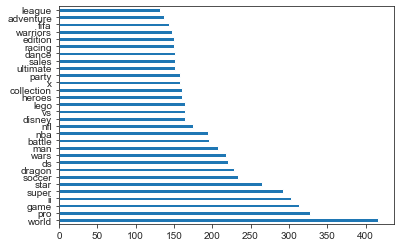

In [ ]:
pd.Series(words).value_counts().head(30).plot(kind='barh')
#下記での1単語の区切りだといまいちシリーズ化しているものが分からない．

単語1語で見るとどうしてもゲームタイトルというよりジャンルの名前になってくるので, ツナガリを1つの単語とみなして count してみます。`nltk` の ngrams を使うのが便利だと思います。

In [ ]:
from nltk.util import ngrams
def line_ngram(line,n=2):
    #先ほどのword
    words=[w for w in line.split(' ') if len(w)>0]
    return list(ngrams(words,n))

In [ ]:
name_grams=names.map(line_ngram)

In [ ]:
grams=[x for row in name_grams for x in row if len(x)>0]

<AxesSubplot:>

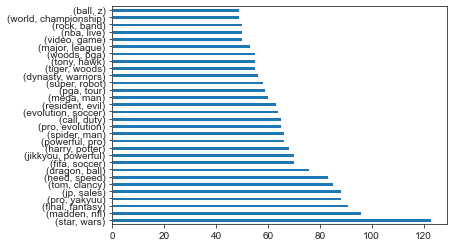

In [ ]:
pd.Series(grams).value_counts().head(30).plot(kind='barh')

<AxesSubplot:>

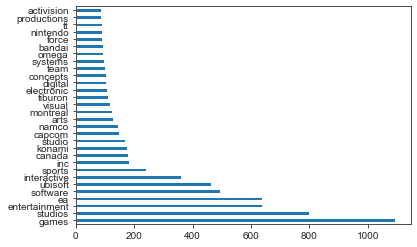

In [ ]:
dev=hero.clean(whole_df['Developer'],custom_pipeline)
words_dev=[w for row in dev.str.split(' ') for w in row if len(w)>0]
pd.Series(words_dev).value_counts().head(30).plot(kind='barh')
#下記での1単語の区切りだといまいちシリーズ化しているものが分からない．

<AxesSubplot:>

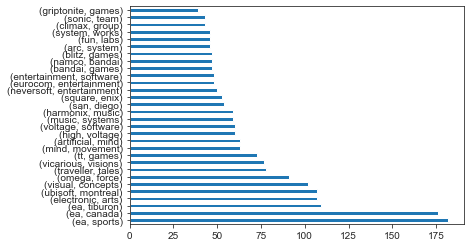

In [ ]:
def line_ngram(line,n=2):
    #先ほどのword
    words_dev=[w for w in line.split(' ') if len(w)>0]
    return list(ngrams(words_dev,n))
dev_grams=dev.map(line_ngram)
grams=[x for row in dev_grams for x in row if len(x)>0]
pd.Series(grams).value_counts().head(30).plot(kind='barh')

### n-gram の特徴量への使い方

上位に20件に属している組み合わせが存在するかどうかを 0-1 のフラグとして持つ方法があるでしょう。

In [ ]:
def clean_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clean_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(30).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')
            



In [ ]:
block = NameNGramBlock(whole_df, n=3)
block.fit(whole_df).head()

,Name_has_jikkyou-powerful-pro_n=3,Name_has_pro-evolution-soccer_n=3,Name_has_powerful-pro-yakyuu_n=3,Name_has_tiger-woods-pga_n=3,Name_has_woods-pga-tour_n=3,Name_has_dragon-ball-z_n=3,Name_has_yu-gi-oh_n=3,Name_has_major-league-baseball_n=3,Name_has_super-robot-taisen_n=3,Name_has_metal-gear-solid_n=3,...,Name_has_tom-clancy-splinter_n=3,Name_has_boy-advance-video_n=3,Name_has_game-boy-advance_n=3,Name_has_tom-clancy-ghost_n=3,Name_has_pro-yaky-spirits_n=3,Name_has_clancy-ghost-recon_n=3,Name_has_clancy-rainbow-six_n=3,Name_has_tony-hawk-pro_n=3,Name_has_tom-clancy-rainbow_n=3,Name_has_hawk-pro-skater_n=3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Developerのn=3gramsの上位20のOneHotEncoding

In [ ]:
class DeveloperNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None):
        dev_grams = create_n_gram(self.whole_df['Developer'], n=self.n)
        grams = [x for row in dev_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(30).index
        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        dev_grams = create_n_gram(input_df['Developer'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = dev_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Developer_has_').add_suffix(f'_n={self.n}')

In [ ]:
#x=create_n_gram(whole_df['Name'])
#grams=[k for row in x for k in row if len(k)>0]
'''
a=pd.DataFrame
k=pd.Series(grams).value_counts().head(20).index
for top in k:
    s_top=('-'.join(top))
    _df['a']=name_grams.map(lambda x: top in x).map(int)

_df['a'].value_counts()
name_grams
'''

"\na=pd.DataFrame\nk=pd.Series(grams).value_counts().head(20).index\nfor top in k:\n    s_top=('-'.join(top))\n    _df['a']=name_grams.map(lambda x: top in x).map(int)\n\n_df['a'].value_counts()\nname_grams\n"

In [ ]:
#s=crean_by_hero(whole_df['Name'])
#pd.Series(s).map(lambda x:line_ngram(x,n=3))

In [ ]:
block_dev=DeveloperNGramBlock(whole_df,n=3)
block_dev.fit(whole_df).head()

,Developer_has_artificial-mind-movement_n=3,Developer_has_high-voltage-software_n=3,Developer_has_harmonix-music-systems_n=3,Developer_has_eurocom-entertainment-software_n=3,Developer_has_namco-bandai-games_n=3,Developer_has_arc-system-works_n=3,Developer_has_milestone-r-l_n=3,Developer_has_bandai-namco-games_n=3,Developer_has_scea-san-diego_n=3,Developer_has_san-diego-studios_n=3,...,Developer_has_monkey-bar-games_n=3,Developer_has_pipeworks-software-inc_n=3,Developer_has_blue-castle-games_n=3,Developer_has_take-two-interactive_n=3,Developer_has_high-moon-studios_n=3,Developer_has_z-axis-ltd_n=3,Developer_has_data-design-interactive_n=3,Developer_has_microsoft-game-studios_n=3,Developer_has_1st-playable-productions_n=3,Developer_has_next-level-games_n=3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
block_dev=DeveloperNGramBlock(whole_df,n=2)
block_dev.fit(whole_df).head()
block_dev.fit(whole_df).head()

,Developer_has_ea-sports_n=2,Developer_has_ea-canada_n=2,Developer_has_ea-tiburon_n=2,Developer_has_electronic-arts_n=2,Developer_has_ubisoft-montreal_n=2,Developer_has_visual-concepts_n=2,Developer_has_omega-force_n=2,Developer_has_traveller-tales_n=2,Developer_has_vicarious-visions_n=2,Developer_has_tt-games_n=2,...,Developer_has_entertainment-software_n=2,Developer_has_bandai-games_n=2,Developer_has_namco-bandai_n=2,Developer_has_blitz-games_n=2,Developer_has_arc-system_n=2,Developer_has_fun-labs_n=2,Developer_has_system-works_n=2,Developer_has_climax-group_n=2,Developer_has_sonic-team_n=2,Developer_has_griptonite-games_n=2
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
block.transform(test_df).sum()

Name_has_jikkyou-powerful-pro_n=3      66
Name_has_pro-evolution-soccer_n=3      64
Name_has_powerful-pro-yakyuu_n=3       62
Name_has_tiger-woods-pga_n=3           55
Name_has_woods-pga-tour_n=3            55
Name_has_dragon-ball-z_n=3             24
Name_has_yu-gi-oh_n=3                  48
Name_has_major-league-baseball_n=3     14
Name_has_super-robot-taisen_n=3        16
Name_has_metal-gear-solid_n=3          36
Name_has_mobile-suit-gundam_n=3        32
Name_has_lego-star-wars_n=3             6
Name_has_teenage-mutant-ninja_n=3      30
Name_has_mutant-ninja-turtles_n=3      30
Name_has_wwe-smackdown-vs_n=3           1
Name_has_smackdown-vs-raw_n=3           1
Name_has_grand-theft-auto_n=3           0
Name_has_shin-megami-tensei_n=3         1
Name_has_dance-dance-revolution_n=3    25
Name_has_clancy-splinter-cell_n=3      26
Name_has_tom-clancy-splinter_n=3       26
Name_has_boy-advance-video_n=3         21
Name_has_game-boy-advance_n=3          21
Name_has_tom-clancy-ghost_n=3     

### Trainにしかない情報を使う

1. そのカラムを予測する (target 以外のカラムを予測する)
2. 他のカラムに集約する

In [ ]:
sales_columns=train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [ ]:
sales_columns

['EU_Sales', 'Global_Sales', 'JP_Sales', 'NA_Sales', 'Other_Sales']

In [ ]:
key='Platform'
input_df=train_df
_df=input_df[sales_columns].groupby(input_df[key]).sum()
_df1=input_df[sales_columns].groupby(input_df[key]).count()
#train_df_copy=train_df.copy()
#pd.merge(train_df_copy[key],_df,on=key,how='left').drop(columns=key)
_df/_df1

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Platform,,,,,
2600,4.556818,80.568182,0.000000,75.170455,0.750000
3DO,0.000000,2.000000,2.000000,0.000000,0.000000
3DS,20.018519,82.159259,31.200000,26.600000,4.296296
DC,3.560976,32.634146,16.195122,12.243902,0.585366
DS,13.197107,53.908680,13.083183,23.631103,3.971971
GB,60.012821,306.987179,92.474359,144.166667,10.269231
GBA,11.676404,50.370787,9.478652,27.777528,1.346067
GC,10.137500,53.812500,8.095833,34.020833,1.462500
GEN,18.380952,94.000000,12.380952,60.095238,3.000000


In [ ]:
class SalesPortfolioBlock(BaseBlock):
    def __init__(self,key:str):
        self.key=key
        self.meta_data=None
    
    def fit(self,input_df):
        _df=input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df=(_df.T/_df.sum(axis=1)).T
        self.meta_data=_df
        return self.transform(input_df)
     
    def transform(self,input_df):
        output_df=pd.merge(input_df[self.key],self.meta_data,on=self.key,how='left').drop(columns=self.key)
        output_df=output_df.add_prefix(f'SP@{self.key}_')
        return output_df





In [ ]:
class SalesSumBlock(BaseBlock):
    def __init__(self,key:str):
        self.key=key
        self.meta_data=None
    
    def fit(self,input_df):
        _df=input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df1=input_df[sales_columns].groupby(input_df[self.key]).count()
        _df=_df/_df1
        self.meta_data=_df
        return self.transform(input_df)
     
    def transform(self,input_df):
        output_df=pd.merge(input_df[self.key],self.meta_data,on=self.key,how='left').drop(columns=self.key)
        output_df=output_df.add_prefix(f'SS@{self.key}_')
        return output_df


In [ ]:
sales=SalesSumBlock('Publisher')
sales.fit(train_df)

,SS@Publisher_EU_Sales,SS@Publisher_Global_Sales,SS@Publisher_JP_Sales,SS@Publisher_NA_Sales,SS@Publisher_Other_Sales
0,21.719149,64.561702,0.468085,34.668085,7.744681
1,28.755556,95.344444,0.222222,55.022222,11.355556
2,21.719149,64.561702,0.468085,34.668085,7.744681
3,7.348774,42.713896,2.918256,29.912807,2.425068
4,21.719149,64.561702,0.468085,34.668085,7.744681
...,...,...,...,...,...
8354,2.695652,3.434783,0.000000,0.304348,0.260870
8355,8.411765,26.588235,0.000000,13.588235,4.588235
8356,0.022556,2.984962,2.548872,0.353383,0.067669
8357,12.630094,42.344828,8.937304,17.015674,3.727273


## Catごとの(Critic_Score,Critic_Count,User_Score)のaggregation処理
* Genre, Publisher, Developer, Platform,ごと
* DeveloperとPublisherはダメ

In [ ]:
key='Platform'
P_df=train_df.groupby(key).agg(['min','max','mean','sum']).drop(sales_columns,axis=1)
_test_df=train_df.copy()
pd.merge(pd.DataFrame(_test_df[key]),P_df,on=key,how='left').drop(key,axis=1).add_prefix(f'{key}')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,"Platform('Year_of_Release', 'min')","Platform('Year_of_Release', 'max')","Platform('Year_of_Release', 'mean')","Platform('Year_of_Release', 'sum')","Platform('Critic_Score', 'min')","Platform('Critic_Score', 'max')","Platform('Critic_Score', 'mean')","Platform('Critic_Score', 'sum')","Platform('Critic_Count', 'min')","Platform('Critic_Count', 'max')","Platform('Critic_Count', 'mean')","Platform('Critic_Count', 'sum')","Platform('User_Count', 'min')","Platform('User_Count', 'max')","Platform('User_Count', 'mean')","Platform('User_Count', 'sum')"
0,2006.0,2014.0,2008.933544,1269646.0,26.0,97.0,63.651568,18268.0,4.0,87.0,23.763066,6820.0,4.0,2147.0,83.617978,22326.0
1,2006.0,2014.0,2008.933544,1269646.0,26.0,97.0,63.651568,18268.0,4.0,87.0,23.763066,6820.0,4.0,2147.0,83.617978,22326.0
2,2004.0,2015.0,2008.716981,1277544.0,28.0,91.0,69.044534,17054.0,4.0,79.0,26.870445,6637.0,4.0,565.0,37.533333,8445.0
3,1980.0,1989.0,1982.013158,150633.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
4,2006.0,2014.0,2008.933544,1269646.0,26.0,97.0,63.651568,18268.0,4.0,87.0,23.763066,6820.0,4.0,2147.0,83.617978,22326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,1988.0,2016.0,2009.089862,871945.0,33.0,96.0,76.106383,25039.0,4.0,104.0,29.735562,9783.0,4.0,9851.0,645.889831,228645.0
8355,1988.0,2016.0,2009.089862,871945.0,33.0,96.0,76.106383,25039.0,4.0,104.0,29.735562,9783.0,4.0,9851.0,645.889831,228645.0
8356,2011.0,2017.0,2014.087866,481367.0,43.0,93.0,72.306667,5423.0,4.0,86.0,29.946667,2246.0,5.0,1228.0,117.930233,10142.0
8357,2013.0,2017.0,2015.155340,415122.0,19.0,97.0,73.172131,8927.0,4.0,113.0,41.442623,5056.0,4.0,7064.0,508.774194,63088.0


In [ ]:
class CatAggBlock(BaseBlock):
    def __init__(self,key:str):
        self.key=key
        self.meta_data=None
    
    def fit(self,input_df):
        self.meta_data=input_df.groupby(self.key).agg(['min','max','mean','sum']).drop(sales_columns,axis=1)
        return self.transform(input_df)
    
    def transform(self,input_df):
        output_df=pd.DataFrame()
        output_df=pd.merge(pd.DataFrame(input_df[self.key]),self.meta_data,on=self.key,how='left').drop(self.key,axis=1).add_prefix(f'{self.key}')
        return output_df
        
        

    

## Catごとのaggregation値との差分

In [ ]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [ ]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

## ブロックの組み合わせ処理

In [ ]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    NameNGramBlock(whole_df, n=2),
    DeveloperNGramBlock(whole_df, n=3),
    DeveloperNGramBlock(whole_df, n=2),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Rating','Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform','Year_of_Release','Publisher','Developer','Rating']],
    *[SalesPortfolioBlock(c) for c in ['Genre','Platform','Rating']],
    *[SalesSumBlock(c) for c in ['Genre','Platform','Rating']],
    *[CatAggBlock(c) for c in ['Genre','Platform','Rating']]
]

In [ ]:
process_blocks

In [ ]:
from tqdm import tqdm
#今回はtrainにしかない特徴量を使って特徴量を作るので次のような仕様になる．
def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)
    #辞書型.get(キー, キーが存在しない場合の返り値)
    #のようにして記述します。2つ目の引数は、辞書型に指定したキーがなかった場合に返される値をしていするためのもので、
    #何も指定しなければNoneが返されることになっています。
    #だからis_trainがTrueだとfitを選択
    #その後blockからfitmethodを選択

    
def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [ ]:
train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks)

  0%|          | 0/26 [00:00<?, ?it/s]

create <__main__.WrapperBlock object at 0x00000260F4D6E430> 0.024[s]
create <__main__.WrapperBlock object at 0x00000260F4D6EB20> 0.050[s]


 12%|█▏        | 3/26 [00:00<00:06,  3.58it/s]

create <__main__.NameNGramBlock object at 0x00000260F4D6E760> 0.753[s]


 15%|█▌        | 4/26 [00:02<00:15,  1.44it/s]

create <__main__.NameNGramBlock object at 0x00000260F4D6E790> 1.633[s]


 19%|█▉        | 5/26 [00:03<00:15,  1.36it/s]

create <__main__.DeveloperNGramBlock object at 0x00000260F4D6E8E0> 0.812[s]


 46%|████▌     | 12/26 [00:04<00:07,  1.88it/s]

create <__main__.DeveloperNGramBlock object at 0x000002608B85A760> 0.773[s]
create <__main__.OneHotBlock object at 0x000002608B85A640> 0.006[s]
create <__main__.OneHotBlock object at 0x000002608B85ABE0> 0.006[s]
create <__main__.OneHotBlock object at 0x000002608B85ABB0> 0.009[s]
create <__main__.OneHotBlock object at 0x000002608B85A820> 0.008[s]
create <__main__.OneHotBlock object at 0x000002608B85A4F0> 0.009[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A3A0> 0.017[s]
create <__main__.CountEncodingBlock object at 0x000002608B85AAF0> 0.009[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A6A0> 0.008[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A490> 0.009[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A0A0> 0.009[s]

 81%|████████  | 21/26 [00:04<00:01,  3.64it/s]


create <__main__.CountEncodingBlock object at 0x000002608B85A5B0> 0.009[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85A880> 0.015[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85AFA0> 0.013[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85A250> 0.009[s]
create <__main__.SalesSumBlock object at 0x000002608B85A1F0> 0.013[s]
create <__main__.SalesSumBlock object at 0x000002608B85ACA0> 0.012[s]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
 92%|█████████▏| 24/26 [00:04<00:00,  4.78it/s]

create <__main__.SalesSumBlock object at 0x000002608B85A370> 0.015[s]
create <__main__.CatAggBlock object at 0x000002608B85A940> 0.081[s]
create <__main__.CatAggBlock object at 0x000002608B85A580> 0.089[s]


  0%|          | 0/26 [00:00<?, ?it/s]

create <__main__.CatAggBlock object at 0x000002608B85AB20> 0.087[s]
create <__main__.WrapperBlock object at 0x00000260F4D6E430> 0.012[s]
create <__main__.WrapperBlock object at 0x00000260F4D6EB20> 0.056[s]


 12%|█▏        | 3/26 [00:00<00:04,  5.53it/s]

create <__main__.NameNGramBlock object at 0x00000260F4D6E760> 0.464[s]


 15%|█▌        | 4/26 [00:01<00:05,  3.74it/s]

create <__main__.NameNGramBlock object at 0x00000260F4D6E790> 0.461[s]


 19%|█▉        | 5/26 [00:01<00:06,  3.33it/s]

create <__main__.DeveloperNGramBlock object at 0x00000260F4D6E8E0> 0.361[s]


 46%|████▌     | 12/26 [00:02<00:03,  3.74it/s]

create <__main__.DeveloperNGramBlock object at 0x000002608B85A760> 0.513[s]
create <__main__.OneHotBlock object at 0x000002608B85A640> 0.005[s]
create <__main__.OneHotBlock object at 0x000002608B85ABE0> 0.006[s]
create <__main__.OneHotBlock object at 0x000002608B85ABB0> 0.005[s]
create <__main__.OneHotBlock object at 0x000002608B85A820> 0.005[s]
create <__main__.OneHotBlock object at 0x000002608B85A4F0> 0.009[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A3A0> 0.036[s]
create <__main__.CountEncodingBlock object at 0x000002608B85AAF0> 0.011[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A6A0> 0.006[s]

 62%|██████▏   | 16/26 [00:02<00:01,  5.13it/s]


create <__main__.CountEncodingBlock object at 0x000002608B85A490> 0.009[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A0A0> 0.013[s]
create <__main__.CountEncodingBlock object at 0x000002608B85A5B0> 0.010[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85A880> 0.014[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85AFA0> 0.010[s]
create <__main__.SalesPortfolioBlock object at 0x000002608B85A250> 0.005[s]


 92%|█████████▏| 24/26 [00:02<00:00,  9.12it/s]

create <__main__.SalesSumBlock object at 0x000002608B85A1F0> 0.007[s]
create <__main__.SalesSumBlock object at 0x000002608B85ACA0> 0.006[s]
create <__main__.SalesSumBlock object at 0x000002608B85A370> 0.007[s]
create <__main__.CatAggBlock object at 0x000002608B85A940> 0.011[s]
create <__main__.CatAggBlock object at 0x000002608B85A580> 0.011[s]
create <__main__.CatAggBlock object at 0x000002608B85AB20> 0.012[s]


100%|██████████| 26/26 [00:02<00:00, 10.53it/s]


In [ ]:
assert len(test_feat_df) == len(test_df)

In [ ]:
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error
    
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values
y = np.log1p(y) # log + plus1 変換する

In [ ]:
from sklearn.model_selection import KFold, GroupKFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [ ]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.905461
[100]	valid_0's rmse: 0.888957
[150]	valid_0's rmse: 0.88362
[200]	valid_0's rmse: 0.881614
[250]	valid_0's rmse: 0.879359
[300]	valid_0's rmse: 0.878536
[350]	valid_0's rmse: 0.877314
[400]	valid_0's rmse: 0.877302
Early stopping, best iteration is:
[382]	valid_0's rmse: 0.876542
fit fold=1 1.444[s]
Fold 0 RMSLE: 0.8765
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.91721
[100]	valid_0's rmse: 0.897471
[150]	valid_0's rmse: 0.887971
[200]	valid_0's rmse: 0.883299
[250]	valid_0's rmse: 0.880833
[300]	valid_0's rmse: 0.879582
[350]	valid_0's rmse: 0.877171
Early stopping, best iteration is:
[339]	valid_0's rmse: 0.876621
fit fold=2 1.290[s]
Fold 1 RMSLE: 0.8766
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.874658
[100]	valid_0's rmse: 0.856536
[150]	valid_0's rmse: 0.85039
[200]	valid_0's rmse: 0.846385
[250]	valid_0's rmse

In [ ]:
def split_by_groups(groups):
    kfold = KFold(n_splits=10, random_state=71, shuffle=True)
    groups = pd.Series(groups)
    
    unique_groups = groups.unique()
    splits = []
    
    def _filter_ids(idx):
        values = unique_groups[idx]
        idx = groups.isin(values)
        return groups[idx].index.values
    
    for idx_tr, idx_val in kfold.split(unique_groups):
        splits.append([
            _filter_ids(idx_tr), _filter_ids(idx_val)
        ])
        
    return splits

In [ ]:
cv = split_by_groups(train_df['Publisher'])
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.969121
[100]	valid_0's rmse: 0.963899
Early stopping, best iteration is:
[76]	valid_0's rmse: 0.959278
fit fold=1 0.552[s]
Fold 0 RMSLE: 0.9593
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.994999
[100]	valid_0's rmse: 0.985303
[150]	valid_0's rmse: 0.989677
Early stopping, best iteration is:
[120]	valid_0's rmse: 0.982627
fit fold=2 0.727[s]
Fold 1 RMSLE: 0.9826
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.995537
[100]	valid_0's rmse: 0.990127
[150]	valid_0's rmse: 0.986597
[200]	valid_0's rmse: 0.983699
[250]	valid_0's rmse: 0.982705
[300]	valid_0's rmse: 0.986872
Early stopping, best iteration is:
[250]	valid_0's rmse: 0.982705
fit fold=3 1.120[s]
Fold 2 RMSLE: 0.9827
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 1.36059
[100]	valid_0's rmse: 1.33919
[150]	valid_0's rmse: 1.33347
[200]	val

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

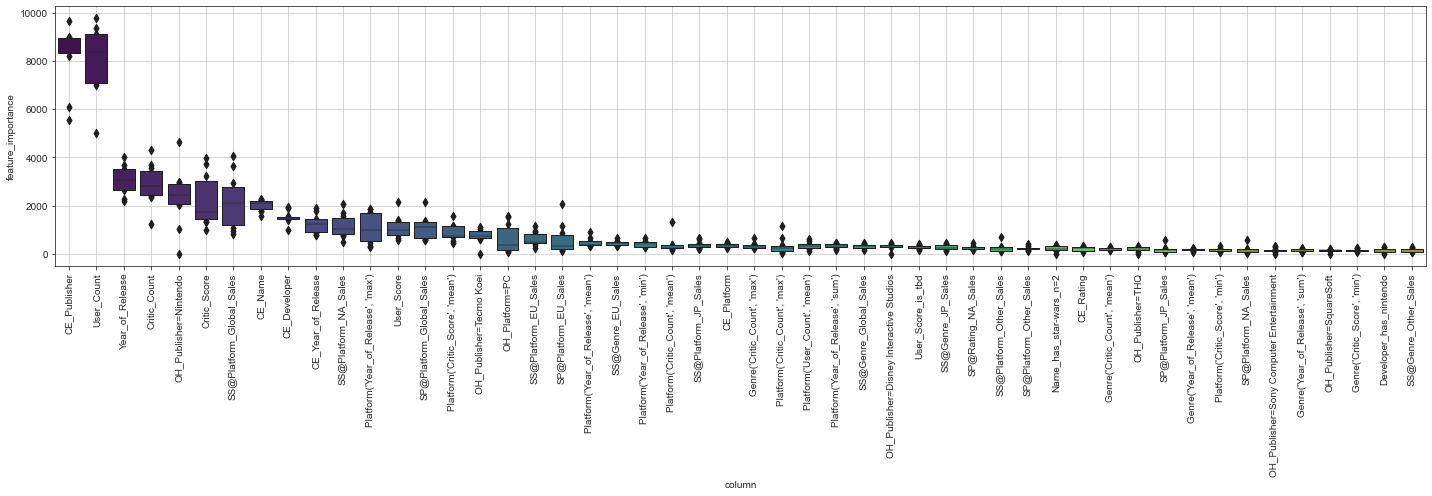

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({'Global_Sales': pred })
sub_df.to_csv('simple_submission.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


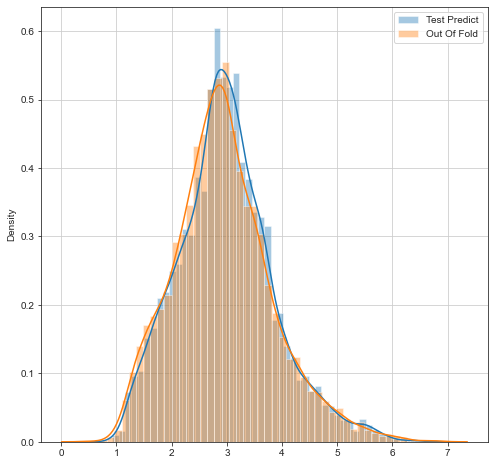

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()

## 特徴量候補リスト

In [ ]:
'''
やったこと
platformごとの集計．人気なplatformは売れる？->集約したら変わらないそう？
・比率で表さず，単純な和で考えると人気なものが分かる？
・シリーズものの上位かどうか．
・CountEncoding項目も追加 OneHotEncoding また別物ものに使うかも
・Genre, Publisher, Developer, Platform, ごとの(Critic_Score,Critic_Count,User_Score)のaggregation処理
・DeveloperNGram,NameNGramの上位30をOneHotEncoding n=2,n=3

やろうとしていること
・PCAで次元削減で回転させる．
・シリーズ化したもののリリース日の差が小さい方が人気なもの？
・リメイク版みたいなのが他のPlatformで出る奴も人気があるということなのでは？->
・jaro距離も用いてシリーズの特定


発見
・Publisherで分割しているとき，Publisherで目的変数を集約するとおかしくなる？
->これはtestとtrainのpublisherの分布が全く異なるため．
・シリーズ化したものの売り上げの平均を特徴量する？->シリーズの中で人気なものはなにか。->これでは，trainにあるシリーズしか特徴量を反映できない
・

'''

'\nやったこと\nplatformごとの集計．人気なplatformは売れる？->集約したら変わらないそう？\n・比率で表さず，単純な和で考えると人気なものが分かる？\n・シリーズものの上位かどうか．\n・CountEncoding項目も追加 OneHotEncoding また別物ものに使うかも\n・Genre, Publisher, Developer, Platform, ごとの(Critic_Score,Critic_Count,User_Score)のaggregation処理\n・DeveloperNGram,NameNGramの上位30をOneHotEncoding n=2,n=3\n\nやろうとしていること\n・PCAで次元削減で回転させる．\n・シリーズ化したもののリリース日の差が小さい方が人気なもの？\n・リメイク版みたいなのが他のPlatformで出る奴も人気があるということなのでは？->\n・jaro距離も用いてシリーズの特定\n\n\n発見\n・Publisherで分割しているとき，Publisherで目的変数を集約するとおかしくなる？\n->これはtestとtrainのpublisherの分布が全く異なるため．\n・シリーズ化したものの売り上げの平均を特徴量する？->シリーズの中で人気なものはなにか。->これでは，trainにあるシリーズしか特徴量を反映できない\n・\n\n'

In [ ]:
train_feat_df

,Critic_Score,Critic_Count,User_Score,User_Count,Year_of_Release,User_Score_is_tbd,Developer_has_japan,Developer_has_nintendo,Developer_has_capcom,Developer_has_sega,...,"Rating('Critic_Score', 'mean')","Rating('Critic_Score', 'sum')","Rating('Critic_Count', 'min')","Rating('Critic_Count', 'max')","Rating('Critic_Count', 'mean')","Rating('Critic_Count', 'sum')","Rating('User_Count', 'min')","Rating('User_Count', 'max')","Rating('User_Count', 'mean')","Rating('User_Count', 'sum')"
0,74.0,17.0,7.9,22.0,NaN,0,0,0,0,0,...,67.586735,39741.0,4.0,88.0,24.52551,14421.0,4.0,4572.0,83.836957,46278.0
1,78.0,22.0,6.6,28.0,NaN,0,0,0,0,0,...,67.586735,39741.0,4.0,88.0,24.52551,14421.0,4.0,4572.0,83.836957,46278.0
2,73.0,5.0,7.4,10.0,NaN,0,0,0,0,0,...,67.586735,39741.0,4.0,88.0,24.52551,14421.0,4.0,4572.0,83.836957,46278.0
3,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76.0,8.0,7.8,13.0,NaN,0,0,0,0,0,...,67.586735,39741.0,4.0,88.0,24.52551,14421.0,4.0,4572.0,83.836957,46278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,78.0,57.0,8.0,569.0,2016.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8355,NaN,NaN,NaN,NaN,2016.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,NaN,NaN,NaN,NaN,2017.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,NaN,NaN,NaN,NaN,2017.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
